In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
books = pd.read_csv("all_books.csv")
books["finished"] = pd.to_datetime(books["finished"])
books["started"] = pd.to_datetime(books["started"])
all_books = books.copy()
books = books[books["finished"].dt.year >= 2015]

books["year_read"] = books["finished"].dt.year
books["month_read"] = books["finished"].dt.month

In [3]:
books[books["finished"].dt.year == 2021]

,title,author,started,finished,reread,imprint,publishing_house,year,pages,duration,...,other_authors,dnf,f_nf,price,genre,narrator,illustrator,translator,year_read,month_read
580,The Tower of Fools (Hussite Trilogy #1),Andrzej Sapkowski,2020-12-29,2021-01-11,1,Orbit,Hachette,2020,549.0,NaN,...,NaN,NaN,f,18.73,fantasy,NaN,NaN,David French,2021,1
584,The Practice,Seth Godin,2021-01-03,2021-01-05,1,Penguin Audio,Penguin Random House,2020,NaN,338.0,...,NaN,NaN,nf,14.99,self-help,Seth Godin,NaN,NaN,2021,1
585,How I Learned to Understand the World,Hans Rosling,2021-01-06,2021-01-25,1,Macmillan Audio,Macmillan,2020,NaN,514.0,...,Fanny Hargestam,NaN,nf,14.99,general nonfiction,Simon Slater; Christina Delaine,NaN,NaN,2021,1
589,Sid Meier's Memoir!,Sid Meier,2021-01-20,2021-01-23,1,W.W. Norton,W. W. Norton,2020,273.0,NaN,...,NaN,NaN,nf,11.26,memoir,NaN,NaN,NaN,2021,1
590,The Trouble With Peace,Joe Abercrombie,2021-01-12,2021-01-20,1,Orbit,Hachette,2020,497.0,NaN,...,NaN,NaN,f,NaN,fantasy,NaN,NaN,NaN,2021,1


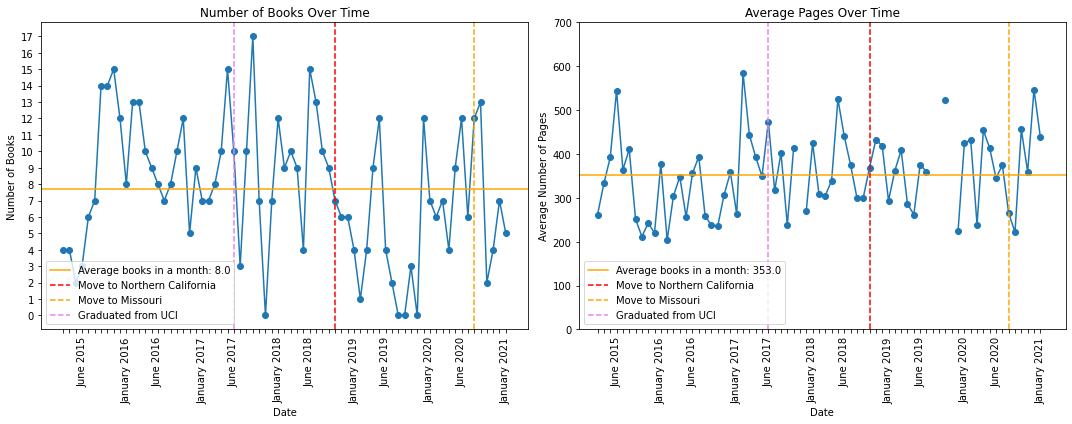

In [34]:
month_order = [
    "January", "February", "March",
    "April", "May", "June",
    "July", "August", "September",
    "October", "November", "December"
]
time_order = []
for year in ["2015", "2016", "2017", "2018", "2019", "2020", "2021"]:
    for month in month_order:
        time_order.append(month + " " + year)


plt.close("all")
data_over_time = books[["title", "finished", "pages", "duration"]].copy()
data_over_time["year_read"] = data_over_time["finished"].dt.year
data_over_time["month_read"] = data_over_time["finished"].dt.month_name()
# data_over_time.dropna(inplace=True)

missing_months = ["August 2019", "September 2019", "November 2019", "November 2017"]
key_series = data_over_time["month_read"] + " " + data_over_time["year_read"].astype("int").astype("str")

data_over_time["timeline"] = pd.Categorical(
    key_series,
    [key for key in time_order if key in np.append(key_series.values, missing_months)],
    ordered=True
)
books_over_time = data_over_time.groupby("timeline")["title"].count().reset_index()

books_over_time.sort_values(by="timeline", inplace=True)

timeline = books_over_time["timeline"]

x_values = [label if label.startswith("January") or label.startswith("June") else "" for label in timeline]

plt.figure(figsize=(15, 6))
ax = plt.subplot(1, 2, 1)
ax.set_xticks(range(len(x_values)))
ax.set_xticklabels(x_values, rotation=90)
ax.set_yticks(range(18))
plt.plot(timeline, books_over_time["title"], marker="o")
plt.title("Number of Books Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Books")
plt.axhline(
    np.mean(books_over_time["title"]), 
    label="Average books in a month: " + str(np.ceil(np.mean(books_over_time["title"]))), 
    color="orange"
)

plt.axvline("October 2018", label="Move to Northern California", color="red", linestyle="--")
plt.axvline("August 2020", label="Move to Missouri", color="orange", linestyle="--")
plt.axvline("June 2017", label="Graduated from UCI", color="violet", linestyle="--")
plt.legend(loc=3)

pages_over_time = data_over_time.groupby("timeline")["pages"].mean().reset_index()
pages_over_time.sort_values(by="timeline", inplace=True)
ax2 = plt.subplot(1, 2, 2)
plt.axis([-3, len(x_values)+3, 0, 700])
plt.plot(timeline, pages_over_time["pages"], marker="o")
ax2.set_xticks(range(len(x_values)))
ax2.set_xticklabels(x_values, rotation=90)
plt.title("Average Pages Over Time")
plt.xlabel("Date")
plt.ylabel("Average Number of Pages")
plt.axhline(
    np.mean(pages_over_time["pages"]), 
    label="Average books in a month: " + str(np.ceil(np.mean(pages_over_time["pages"]))), 
    color="orange"
)

plt.axvline("October 2018", label="Move to Northern California", color="red", linestyle="--")
plt.axvline("August 2020", label="Move to Missouri", color="orange", linestyle="--")
plt.axvline("June 2017", label="Graduated from UCI", color="violet", linestyle="--")
plt.legend(loc=3)
plt.tight_layout()

plt.show()

In [5]:
books_over_time

,timeline,title
0,March 2015,4
1,April 2015,4
2,May 2015,2
3,June 2015,3
4,July 2015,6
...,...,...
66,September 2020,13
67,October 2020,2
68,November 2020,4
69,December 2020,7


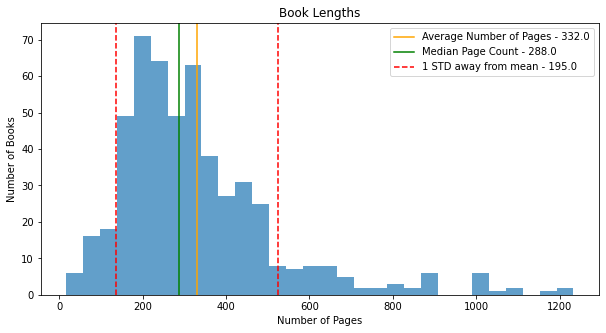

In [6]:
plt.close("all")
plt.figure(figsize=(10,5))
ax = plt.subplot()

page_counts = books[(books["dnf"] != "x")]["pages"].dropna()
plt.hist(page_counts, bins=30, alpha=0.7)

plt.title("Book Lengths")
plt.ylabel("Number of Books")
plt.xlabel("Number of Pages")

plt.axvline(np.mean(page_counts), color="orange", label=f"Average Number of Pages - {np.ceil(np.mean(page_counts))}")
plt.axvline(np.median(page_counts), color="green", label=f"Median Page Count - {np.ceil(np.median(page_counts))}")

page_std = np.std(page_counts)
plt.axvline(np.mean(page_counts) + page_std, linestyle="--", color="red", label=f"1 STD away from mean - {np.round(page_std)}")
plt.axvline(np.mean(page_counts) - page_std, linestyle="--", color="red")
plt.legend()

plt.show()

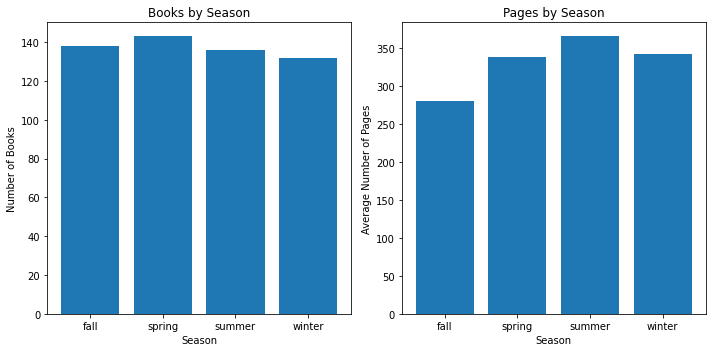

In [7]:
plt.close("all")

spring = ["March", "April", "May"]
summer = ["June", "July", "August"]
fall = ["September", "October", "November"]
winter = ["December", "January", "February"]

book_seasons = books[["title", "finished", "pages"]].copy()

book_seasons.loc[book_seasons["finished"].dt.month_name().isin(spring), "season"] = "spring"
book_seasons.loc[book_seasons["finished"].dt.month_name().isin(summer), "season"] = "summer"
book_seasons.loc[book_seasons["finished"].dt.month_name().isin(fall), "season"] = "fall"
book_seasons.loc[book_seasons["finished"].dt.month_name().isin(winter), "season"] = "winter"

counts_by_season = book_seasons.groupby("season")["title"].count().reset_index()
pages_by_season = book_seasons.groupby("season")["pages"].mean().reset_index()

plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1)

# 2019 is missing data for August, September, and November (Two fall months...)
plt.bar(range(4), counts_by_season["title"])
ax.set_xticks(range(4))
ax.set_xticklabels(counts_by_season["season"])
plt.title("Books by Season")
plt.xlabel("Season")
plt.ylabel("Number of Books")

ax2 = plt.subplot(1, 2, 2)
plt.bar(range(4), pages_by_season["pages"])
ax2.set_xticks(range(4))
ax2.set_xticklabels(pages_by_season["season"])
plt.title("Pages by Season")
plt.xlabel("Season")
plt.ylabel("Average Number of Pages")

plt.tight_layout()

plt.show()

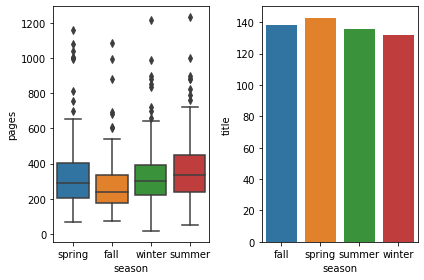

In [32]:
plt.clf()
plt.subplot(1, 2, 1)
sns.boxplot(data=book_seasons, x="season", y="pages")
plt.subplot(1, 2, 2)
sns.barplot(data=counts_by_season, x="season", y="title")
plt.tight_layout()
plt.show()

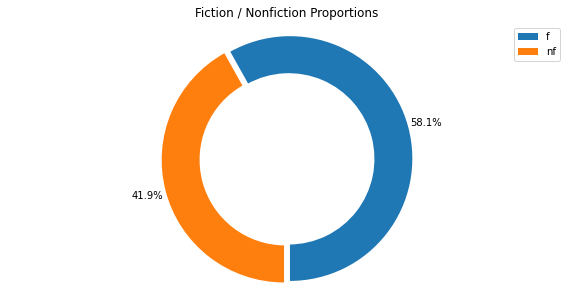

In [8]:
plt.close("all")

f_nf = books[(books["dnf"] != "x")][["title", "f_nf"]].copy()
f_nf = f_nf.groupby("f_nf")["title"].count().reset_index()
f_nf["pcts"] = f_nf["title"].div(f_nf["title"].sum())

plt.figure(figsize=(10, 5))
ax = plt.subplot()
plt.pie(f_nf["pcts"], autopct="%0.1f%%", pctdistance=1.15, startangle=270, explode=[0.05, 0])
plt.pie(f_nf["pcts"], radius=0.7, colors=["white", "white"], explode=[0.04, -0.01], startangle=270)
plt.axis("equal")
plt.legend(f_nf["f_nf"])

plt.title("Fiction / Nonfiction Proportions")
plt.show()

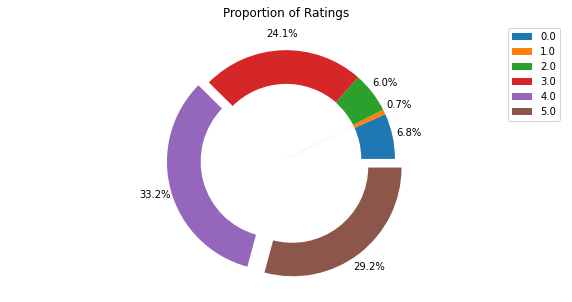

In [9]:
plt.close("all")

ratings = books[["title", "rating"]].copy().dropna()

ratings = ratings.groupby("rating")["title"].count().reset_index()
# ratings["pct_of_total"] = ratings["title"].apply(lambda x: x / ratings["title"].sum())
ratings["pct_of_total"] = ratings["title"].div(ratings["title"].sum())
plt.figure(figsize=(10, 5))
plt.axis("equal")
plt.pie(ratings["pct_of_total"], autopct="%0.1f%%", pctdistance=1.15, explode=[0, 0, 0, 0, 0.1, 0.1])
plt.pie(ratings["pct_of_total"], explode=[x-0.01 for x in [0, 0, 0, 0, 0.1, 0.1]], radius=0.7, colors=["white"]*len(ratings["pct_of_total"]))
plt.legend(ratings["rating"])
plt.title("Proportion of Ratings")
plt.show()

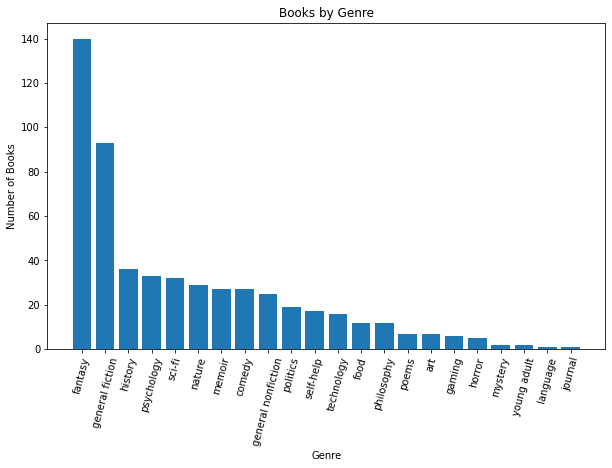

In [10]:
plt.close("all")

books_by_genre = books[~(books["finished"].isna())][["title", "genre"]].copy().dropna()
books_by_genre = books_by_genre.groupby("genre")["title"].count().reset_index().sort_values(by="title", ascending=False)

plt.figure(figsize=(10, 6))
ax = plt.subplot()

plt.bar(range(len(books_by_genre["genre"])), books_by_genre["title"])

ax.set_xticks(range(len(books_by_genre["genre"])))
ax.set_xticklabels(books_by_genre["genre"], rotation=75)

plt.title("Books by Genre")
plt.xlabel("Genre")
plt.ylabel("Number of Books")
plt.show()

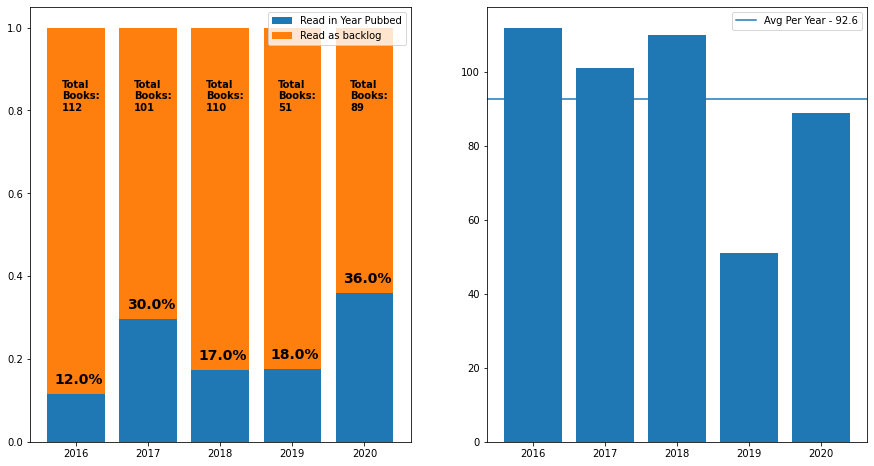

In [11]:
plt.close("all")

books_read_in_2016 = books[
    (books["finished"].dt.year == 2016)
    & (books["year"] == 2016)
]

books_read_in_2017 = books[
    (books["finished"].dt.year == 2017)
    & (books["year"] == 2017)
]

books_read_in_2018 = books[
    (books["finished"].dt.year == 2018)
    & (books["year"] == 2018)
]
books_read_in_2019 = books[
    (books["finished"].dt.year == 2019)
    & (books["year"] == 2019)
]
books_read_in_2020 = books[
    (books["finished"].dt.year == 2020)
    & (books["year"] == 2020)
]

plt.figure(figsize=(15, 8))
ax = plt.subplot(1,2,1)

x_values = ["2016", "2017", "2018", "2019", "2020"]
y_2016 = len(books_read_in_2016) / len(books[books["finished"].dt.year == 2016])
y_2017 = len(books_read_in_2017) / len(books[books["finished"].dt.year == 2017])
y_2018 = len(books_read_in_2018) / len(books[books["finished"].dt.year == 2018])
y_2019 = len(books_read_in_2019)/ len(books[books["finished"].dt.year == 2019])
y_2020 = len(books_read_in_2020)/ len(books[books["finished"].dt.year == 2020])

plt.bar(range(5), [y_2016, y_2017, y_2018, y_2019, y_2020], label="Read in Year Pubbed")

for idx, value in enumerate([y_2016, y_2017, y_2018, y_2019, y_2020]):
    ax.text(idx-0.3, value+0.025, str(round(value, 2)*100) + "%", fontweight="bold", fontsize=14)

totals = [len(books[books["finished"].dt.year == 2016]),
    len(books[books["finished"].dt.year == 2017]),
    len(books[books["finished"].dt.year == 2018]),
    len(books[books["finished"].dt.year == 2019]),
    len(books[books["finished"].dt.year == 2020])]
for idx, value in enumerate(totals):
    ax.text(idx-0.2, 0.8, "Total\nBooks:\n" + str(value), fontweight="bold")

plt.bar(range(5), [1-y_2016, 1-y_2017, 1-y_2018, 1-y_2019, 1-y_2020], bottom=[y_2016, y_2017, y_2018, y_2019, y_2020], label="Read as backlog")
plt.legend()
ax.set_xticks(range(5))
ax.set_xticklabels(x_values)

ax2 = plt.subplot(1, 2, 2)
plt.bar(range(5), totals)
ax2.set_xticks(range(5))
ax2.set_xticklabels(x_values)
plt.axhline(np.mean(totals), label=f"Avg Per Year - {np.mean(totals)}")
plt.legend()
plt.show()

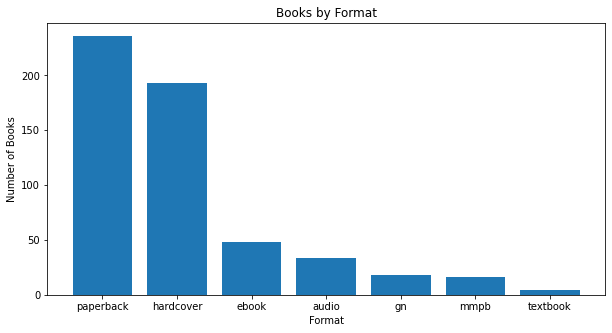

In [12]:
plt.close("all")
books_by_format = books[~books["finished"].isna()].groupby("format")["title"].count().reset_index().sort_values(by="title", ascending=False)
x_values = books_by_format["format"]
y_values = books_by_format["title"]

plt.figure(figsize=(10, 5))
ax = plt.subplot()
plt.bar(range(len(x_values)), y_values)
ax.set_xticks(range(len(x_values)))
ax.set_xticklabels(x_values)
plt.title("Books by Format")
plt.xlabel("Format")
plt.ylabel("Number of Books")
plt.show()


In [13]:
np.median(books["reread"])

1.0

In [14]:
books["days_to_finish"] = (books["finished"] - books["started"]).dt.days

In [15]:
books

,title,author,started,finished,reread,imprint,publishing_house,year,pages,duration,...,dnf,f_nf,price,genre,narrator,illustrator,translator,year_read,month_read,days_to_finish
0,Uzumaki,Junji Ito,NaT,2017-05-17,1,Viz Media,Viz Media,2000,656.0,NaN,...,NaN,f,NaN,horror,NaN,NaN,NaN,2017,5,NaN
1,The Shallows: What the Internet Is Doing to Ou...,Nicholas Carr,NaT,2017-10-01,2,Norton,W. W. Norton,2010,280.0,NaN,...,NaN,nf,NaN,technology,NaN,NaN,NaN,2017,10,NaN
2,The Sixth Extinction: An Unnatural History,Elizabeth Kolbert,NaT,2015-03-06,2,Henry Holt,Macmillan,2014,336.0,NaN,...,NaN,nf,NaN,nature,NaN,NaN,NaN,2015,3,NaN
3,The Name of the Wind (The Kingkiller Chronicle...,Patrick Rothfuss,NaT,2017-02-28,3,DAW,Penguin Random House,2007,662.0,NaN,...,NaN,f,NaN,fantasy,NaN,NaN,NaN,2017,2,NaN
4,"The Wise Man's Fear (The Kingkiller Chronicle,...",Patrick Rothfuss,NaT,2017-03-13,3,DAW,Penguin Random House,2011,994.0,NaN,...,NaN,f,NaN,fantasy,NaN,NaN,NaN,2017,3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,The Practice,Seth Godin,2021-01-03,2021-01-05,1,Penguin Audio,Penguin Random House,2020,NaN,338.0,...,NaN,nf,14.99,self-help,Seth Godin,NaN,NaN,2021,1,2.0
585,How I Learned to Understand the World,Hans Rosling,2021-01-06,2021-01-25,1,Macmillan Audio,Macmillan,2020,NaN,514.0,...,NaN,nf,14.99,general nonfiction,Simon Slater; Christina Delaine,NaN,NaN,2021,1,19.0
587,The Office of Historical Corrections,Danielle Evans,2020-12-27,2020-12-28,1,Riverhead,Penguin Random House,2020,265.0,NaN,...,NaN,f,16.45,general fiction,NaN,NaN,NaN,2020,12,1.0
589,Sid Meier's Memoir!,Sid Meier,2021-01-20,2021-01-23,1,W.W. Norton,W. W. Norton,2020,273.0,NaN,...,NaN,nf,11.26,memoir,NaN,NaN,NaN,2021,1,3.0


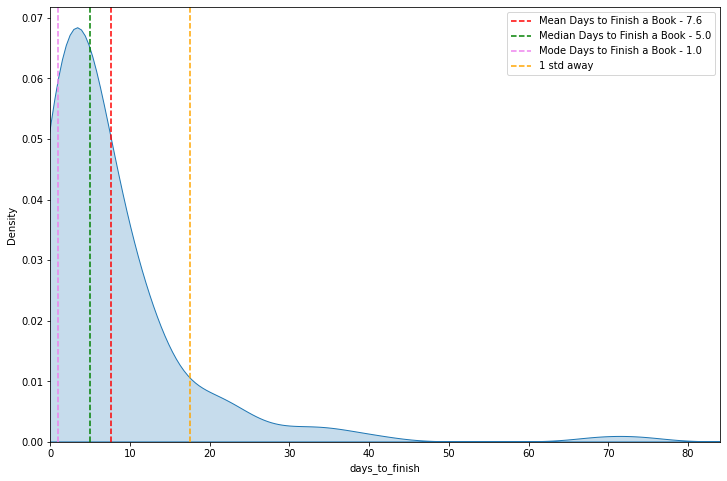

In [16]:
plt.close("all")
plt.figure(figsize=(12, 8))
sns.kdeplot(data=books, x="days_to_finish", shade=True)
mean_days = np.mean(books["days_to_finish"])
median_days = np.median(books[["days_to_finish"]].dropna()["days_to_finish"])
mode_days, mode_counts = stats.mode(books[["days_to_finish"]].dropna()["days_to_finish"])
std_days = np.std(books["days_to_finish"])
plt.axvline(mean_days, label=f"Mean Days to Finish a Book - {np.round(mean_days, 1)}", color="red", linestyle="--")
plt.axvline(median_days, label=f"Median Days to Finish a Book - {median_days}", color="green", linestyle="--")
plt.axvline(mode_days, label=f"Mode Days to Finish a Book - {mode_days[0]}", color="violet", linestyle="--")
plt.axvline(mean_days + std_days, label="1 std away", color="orange", linestyle="--")
plt.xlim([0, int(books["days_to_finish"].max())+10])
plt.legend()
plt.show()

In [17]:
mode_days

array([1.])

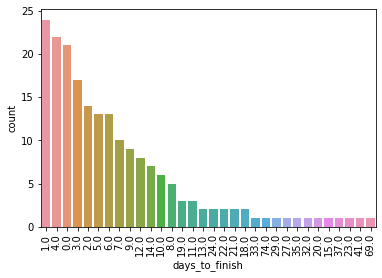

In [18]:
plt.close("all")
sns.countplot(x=books["days_to_finish"], order=books["days_to_finish"].value_counts().index)
plt.xticks(rotation=90)
plt.show()

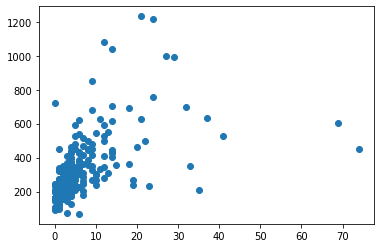

In [19]:
plt.close("all")
plt.scatter(x=books["days_to_finish"], y=books["pages"])
plt.show()

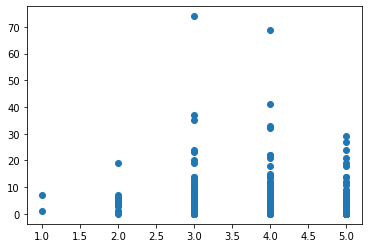

In [20]:
plt.close("all")
plt.scatter(x=books["rating"], y=books["days_to_finish"])
plt.show()

In [21]:
books.describe()

,reread,year,pages,duration,rating,price,year_read,month_read,days_to_finish
count,549.000000,549.000000,520.000000,29.000000,548.000000,83.000000,549.000000,549.000000,197.000000
mean,1.089253,1997.020036,331.240385,512.724138,3.638686,15.761566,2017.409836,6.597450,7.614213
std,0.315727,103.437865,194.815841,218.286492,1.338817,12.767543,1.675710,3.383633,9.949536
min,0.000000,180.000000,17.000000,119.000000,0.000000,0.000000,2015.000000,1.000000,0.000000
25%,1.000000,2004.000000,204.000000,396.000000,3.000000,4.990000,2016.000000,4.000000,2.000000
50%,1.000000,2013.000000,288.000000,463.000000,4.000000,16.450000,2017.000000,7.000000,5.000000
75%,1.000000,2017.000000,400.000000,625.000000,5.000000,22.775000,2019.000000,9.000000,9.000000
max,3.000000,2020.000000,1233.000000,1115.000000,5.000000,58.160000,2021.000000,12.000000,74.000000


# Challenge: Find Associations Between Different Categorical Variables

In [22]:
books.head()

,title,author,started,finished,reread,imprint,publishing_house,year,pages,duration,...,dnf,f_nf,price,genre,narrator,illustrator,translator,year_read,month_read,days_to_finish
0,Uzumaki,Junji Ito,NaT,2017-05-17,1,Viz Media,Viz Media,2000,656.0,NaN,...,NaN,f,NaN,horror,NaN,NaN,NaN,2017,5,NaN
1,The Shallows: What the Internet Is Doing to Ou...,Nicholas Carr,NaT,2017-10-01,2,Norton,W. W. Norton,2010,280.0,NaN,...,NaN,nf,NaN,technology,NaN,NaN,NaN,2017,10,NaN
2,The Sixth Extinction: An Unnatural History,Elizabeth Kolbert,NaT,2015-03-06,2,Henry Holt,Macmillan,2014,336.0,NaN,...,NaN,nf,NaN,nature,NaN,NaN,NaN,2015,3,NaN
3,The Name of the Wind (The Kingkiller Chronicle...,Patrick Rothfuss,NaT,2017-02-28,3,DAW,Penguin Random House,2007,662.0,NaN,...,NaN,f,NaN,fantasy,NaN,NaN,NaN,2017,2,NaN
4,"The Wise Man's Fear (The Kingkiller Chronicle,...",Patrick Rothfuss,NaT,2017-03-13,3,DAW,Penguin Random House,2011,994.0,NaN,...,NaN,f,NaN,fantasy,NaN,NaN,NaN,2017,3,NaN


In [23]:
pd.crosstab(books["f_nf"], books["genre"])

genre,art,comedy,fantasy,food,gaming,general fiction,general nonfiction,history,horror,journal,...,mystery,nature,philosophy,poems,politics,psychology,sci-fi,self-help,technology,young adult
f_nf,,,,,,,,,,,,,,,,,,,,,
f,7,27,140,0,1,93,1,0,5,1,...,2,0,0,7,0,0,32,0,1,2
nf,0,0,0,12,5,0,24,36,0,0,...,0,29,12,0,19,33,0,17,15,0


In [24]:
books["genre"].value_counts()

fantasy               140
general fiction        93
history                36
psychology             33
sci-fi                 32
nature                 29
comedy                 27
memoir                 27
general nonfiction     25
politics               19
self-help              17
technology             16
food                   12
philosophy             12
art                     7
poems                   7
gaming                  6
horror                  5
young adult             2
mystery                 2
language                1
journal                 1
Name: genre, dtype: int64